# ЫЫЫЫЫЫЫЫЫЫЫЫ

In [33]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt

In [2]:
!pip freeze | grep "numpy\|pandas\|lightgbm\|scikit-learn"

geopandas==0.13.2
lightgbm==4.1.0
numpy==1.25.2
pandas==1.5.3
pandas-datareader==0.10.0
pandas-gbq==0.19.2
pandas-stubs==1.5.3.230304
scikit-learn==1.2.2
sklearn-pandas==2.2.0


## Загрузка данных

In [2]:
train_df = pd.read_parquet("train_data.pqt")
test_df = pd.read_parquet("test_data.pqt")

In [18]:
train_df.head(3)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",{other}
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.948812,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}",{other}
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.946458,0.442244,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}",{other}


In [28]:
train_df.describe(include="all")

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
count,600000.000000,600000,5.344230e+05,5.344230e+05,5.344230e+05,5.344230e+05,557150,521656,521656,274776,...,434748.000000,434748.000000,6.000000e+05,434748.000000,434748.000000,6.000000e+05,434748.000000,434748.000000,600000,600000
unique,NaN,3,NaN,NaN,NaN,NaN,45,8917,7931,233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,17
top,NaN,month_1,NaN,NaN,NaN,NaN,channel_code_8,city_0,city_type_0,index_city_code_46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{α},{α}
freq,NaN,200000,NaN,NaN,NaN,NaN,102296,86234,464866,9548,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,375947,318670
mean,99999.500000,NaN,5.291614e-18,-7.312532e-17,-3.959403e-17,-9.945043e-18,NaN,NaN,NaN,NaN,...,0.946172,0.410920,3.422448e-18,0.551292,0.507565,4.041212e-17,0.255424,0.456226,NaN,NaN
std,57735.075031,NaN,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,NaN,NaN,NaN,NaN,...,0.011519,0.080259,1.000001e+00,0.014255,0.156156,1.000001e+00,0.017320,0.136101,NaN,NaN
min,0.000000,NaN,-1.567780e-01,-2.049624e-01,-1.259950e-01,-1.563145e-01,NaN,NaN,NaN,NaN,...,0.944497,0.384773,-1.655883e-01,0.546889,0.407687,-2.011323e-01,0.250924,0.374540,NaN,NaN
25%,49999.750000,NaN,-1.560927e-01,-2.042761e-01,-1.259122e-01,-1.556526e-01,NaN,NaN,NaN,NaN,...,0.944497,0.384773,-1.655881e-01,0.546889,0.407687,-2.011227e-01,0.250924,0.374540,NaN,NaN
50%,99999.500000,NaN,-1.499485e-01,-1.903097e-01,-1.248704e-01,-1.495861e-01,NaN,NaN,NaN,NaN,...,0.944497,0.384773,-1.655881e-01,0.547176,0.429909,-2.011227e-01,0.251501,0.396518,NaN,NaN
75%,149999.250000,NaN,-1.033781e-01,-1.063255e-01,-1.124800e-01,-1.033203e-01,NaN,NaN,NaN,NaN,...,0.944889,0.396267,-1.436181e-01,0.549755,0.541020,-1.384441e-01,0.254101,0.473441,NaN,NaN


In [5]:
test_df.head(3)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
0,200000,month_4,-0.155447,-0.203866,-0.122699,-0.154980,channel_code_0,city_0,city_type_0,None,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
1,200000,month_5,-0.155452,-0.203966,-0.122699,-0.154984,channel_code_0,city_0,city_type_0,None,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
2,200000,month_6,-0.155452,-0.203966,-0.122699,-0.154984,channel_code_0,city_0,city_type_0,None,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,None


In [3]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year",
]

Обозначение категориальных признаков

In [4]:
train_df[cat_cols] = train_df[cat_cols].astype("category")
test_df[cat_cols] = test_df[cat_cols].astype("category")

In [5]:
df_num = train_df.select_dtypes(include=[np.number])
numeric_cols = df_num.columns.values

for col in numeric_cols:
    missing = train_df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:
        print('imputing missing values for: {}'.format(col))
        train_df['{}_ismissing'.format(col)] = missing
        med = train_df[col].median()
        train_df[col] = train_df[col].fillna(med)



df_num_2 = test_df.select_dtypes(include=[np.number])
numeric_cols_2 = df_num_2.columns.values

for col in numeric_cols_2:
    missing = test_df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:
        print('imputing missing values for: {}'.format(col))
        train_df['{}_ismissing'.format(col)] = missing
        med = train_df[col].median()
        train_df[col] = train_df[col].fillna(med)

imputing missing values for: balance_amt_avg
imputing missing values for: balance_amt_max
imputing missing values for: balance_amt_min
imputing missing values for: balance_amt_day_avg
imputing missing values for: ogrn_days_end_month
imputing missing values for: ogrn_days_end_quarter
imputing missing values for: ft_registration_date
imputing missing values for: max_founderpres
imputing missing values for: min_founderpres
imputing missing values for: ogrn_exist_months
imputing missing values for: sum_of_paym_2m
imputing missing values for: sum_of_paym_6m
imputing missing values for: sum_of_paym_1y
imputing missing values for: cnt_a_oper_1m
imputing missing values for: cnt_b_oper_1m
imputing missing values for: cnt_c_oper_1m
imputing missing values for: cnt_deb_d_oper_1m
imputing missing values for: cnt_cred_d_oper_1m
imputing missing values for: cnt_deb_e_oper_1m
imputing missing values for: cnt_days_deb_e_oper_1m
imputing missing values for: cnt_cred_e_oper_1m
imputing missing values fo

C:\Users\User\AppData\Local\Temp\ipykernel_13020\4079182862.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\4079182862.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\4079182862.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: cnt_cred_g_oper_3m
imputing missing values for: cnt_days_cred_g_oper_3m
imputing missing values for: cnt_deb_h_oper_3m
imputing missing values for: cnt_days_deb_h_oper_3m
imputing missing values for: cnt_cred_h_oper_3m
imputing missing values for: cnt_days_cred_h_oper_3m
imputing missing values for: balance_amt_avg


C:\Users\User\AppData\Local\Temp\ipykernel_13020\4079182862.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\4079182862.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\4079182862.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: balance_amt_max
imputing missing values for: balance_amt_min
imputing missing values for: balance_amt_day_avg
imputing missing values for: ogrn_days_end_month
imputing missing values for: ogrn_days_end_quarter
imputing missing values for: ft_registration_date
imputing missing values for: max_founderpres
imputing missing values for: min_founderpres
imputing missing values for: ogrn_exist_months
imputing missing values for: sum_of_paym_2m
imputing missing values for: sum_of_paym_6m
imputing missing values for: sum_of_paym_1y
imputing missing values for: cnt_a_oper_1m
imputing missing values for: cnt_b_oper_1m
imputing missing values for: cnt_c_oper_1m
imputing missing values for: cnt_deb_d_oper_1m
imputing missing values for: cnt_cred_d_oper_1m
imputing missing values for: cnt_deb_e_oper_1m
imputing missing values for: cnt_days_deb_e_oper_1m
imputing missing values for: cnt_cred_e_oper_1m
imputing missing values for: cnt_days_cred_e_oper_1m
imputing missing v

In [6]:
df_non_numeric = train_df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values

for col in non_numeric_cols:
    missing = train_df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  # only do the imputation for the columns that have missing values.
        print('imputing missing values for: {}'.format(col))
        train_df['{}_ismissing'.format(col)] = missing
        
        top = train_df[col].describe()['top'] # impute with the most frequent value.
        train_df[col] = train_df[col].fillna(top)

imputing missing values for: channel_code
imputing missing values for: city
imputing missing values for: city_type
imputing missing values for: index_city_code
imputing missing values for: ogrn_month
imputing missing values for: ogrn_year
imputing missing values for: okved
imputing missing values for: segment
imputing missing values for: balance_amt_avg_ismissing
imputing missing values for: balance_amt_max_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: balance_amt_min_ismissing
imputing missing values for: balance_amt_day_avg_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing


imputing missing values for: ogrn_days_end_month_ismissing
imputing missing values for: ogrn_days_end_quarter_ismissing
imputing missing values for: ft_registration_date_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: max_founderpres_ismissing
imputing missing values for: min_founderpres_ismissing
imputing missing values for: ogrn_exist_months_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: sum_of_paym_2m_ismissing
imputing missing values for: sum_of_paym_6m_ismissing
imputing missing values for: sum_of_paym_1y_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: cnt_a_oper_1m_ismissing
imputing missing values for: cnt_b_oper_1m_ismissing
imputing missing values for: cnt_c_oper_1m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: cnt_deb_d_oper_1m_ismissing
imputing missing values for: cnt_cred_d_oper_1m_ismissing
imputing missing values for: cnt_deb_e_oper_1m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: cnt_days_deb_e_oper_1m_ismissing
imputing missing values for: cnt_cred_e_oper_1m_ismissing
imputing missing values for: cnt_days_cred_e_oper_1m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: cnt_deb_f_oper_1m_ismissing
imputing missing values for: cnt_days_deb_f_oper_1m_ismissing
imputing missing values for: cnt_cred_f_oper_1m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: cnt_days_cred_f_oper_1m_ismissing
imputing missing values for: cnt_deb_g_oper_1m_ismissing
imputing missing values for: cnt_days_deb_g_oper_1m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: cnt_cred_g_oper_1m_ismissing
imputing missing values for: cnt_days_cred_g_oper_1m_ismissing
imputing missing values for: cnt_deb_h_oper_1m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: cnt_days_deb_h_oper_1m_ismissing
imputing missing values for: cnt_cred_h_oper_1m_ismissing
imputing missing values for: cnt_days_cred_h_oper_1m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: cnt_a_oper_3m_ismissing
imputing missing values for: cnt_b_oper_3m_ismissing
imputing missing values for: cnt_c_oper_3m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: cnt_deb_d_oper_3m_ismissing
imputing missing values for: cnt_cred_d_oper_3m_ismissing
imputing missing values for: cnt_deb_e_oper_3m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: cnt_days_deb_e_oper_3m_ismissing
imputing missing values for: cnt_cred_e_oper_3m_ismissing
imputing missing values for: cnt_days_cred_e_oper_3m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: cnt_deb_f_oper_3m_ismissing
imputing missing values for: cnt_days_deb_f_oper_3m_ismissing
imputing missing values for: cnt_cred_f_oper_3m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: cnt_days_cred_f_oper_3m_ismissing
imputing missing values for: cnt_deb_g_oper_3m_ismissing
imputing missing values for: cnt_days_deb_g_oper_3m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: cnt_cred_g_oper_3m_ismissing
imputing missing values for: cnt_days_cred_g_oper_3m_ismissing
imputing missing values for: cnt_deb_h_oper_3m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

imputing missing values for: cnt_days_deb_h_oper_3m_ismissing
imputing missing values for: cnt_cred_h_oper_3m_ismissing
imputing missing values for: cnt_days_cred_h_oper_3m_ismissing


C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\2461222913.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

In [7]:
misss = train_df.isnull()
misss.head(40)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_f_oper_3m_ismissing_ismissing,cnt_days_cred_f_oper_3m_ismissing_ismissing,cnt_deb_g_oper_3m_ismissing_ismissing,cnt_days_deb_g_oper_3m_ismissing_ismissing,cnt_cred_g_oper_3m_ismissing_ismissing,cnt_days_cred_g_oper_3m_ismissing_ismissing,cnt_deb_h_oper_3m_ismissing_ismissing,cnt_days_deb_h_oper_3m_ismissing_ismissing,cnt_cred_h_oper_3m_ismissing_ismissing,cnt_days_cred_h_oper_3m_ismissing_ismissing
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Создаем выборки для валидации и обучения

In [7]:
X = train_df.drop(["id", "date", "end_cluster"], axis=1)
y = train_df["end_cluster"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

In [32]:
print(x_train)

        balance_amt_avg  balance_amt_max  balance_amt_min  \
501294        -0.156509        -0.203728        -0.125995   
285039        -0.156745        -0.204938        -0.125914   
47556         -0.149948        -0.190310        -0.124870   
580653        -0.151900        -0.195730        -0.125735   
547794        -0.151549        -0.199588        -0.119804   
...                 ...              ...              ...   
110268        -0.156287        -0.196178        -0.125995   
259178        -0.144212        -0.182970        -0.119285   
365838        -0.149948        -0.190310        -0.124870   
131932        -0.156115        -0.204464        -0.124347   
121958        -0.111009        -0.061238        -0.121245   

        balance_amt_day_avg     channel_code       city    city_type  \
501294            -0.156044   channel_code_8   city_202  city_type_0   
285039            -0.156282   channel_code_7    city_98  city_type_0   
47556             -0.149586   channel_code_8     ci

## Обучение модели

В качестве базовой модели возьмем LGBM обучим на всех признаках

In [8]:
model_1 = CatBoostClassifier(iterations=15, learning_rate=0.1, depth=8, cat_features=cat_cols)
model_1.fit(x_train, y_train)

0:	learn: 2.0522141	total: 19.6s	remaining: 4m 33s
1:	learn: 1.8040082	total: 40s	remaining: 4m 20s
2:	learn: 1.6373783	total: 1m	remaining: 4m 1s
3:	learn: 1.5143009	total: 1m 22s	remaining: 3m 45s
4:	learn: 1.4198012	total: 1m 43s	remaining: 3m 26s
5:	learn: 1.3444237	total: 2m 5s	remaining: 3m 8s
6:	learn: 1.2817581	total: 2m 28s	remaining: 2m 50s
7:	learn: 1.2298462	total: 2m 51s	remaining: 2m 30s
8:	learn: 1.1854108	total: 3m 13s	remaining: 2m 9s
9:	learn: 1.1479727	total: 3m 36s	remaining: 1m 48s
10:	learn: 1.1153072	total: 3m 58s	remaining: 1m 26s
11:	learn: 1.0875159	total: 4m 22s	remaining: 1m 5s
12:	learn: 1.0620029	total: 4m 46s	remaining: 44.1s
13:	learn: 1.0396699	total: 5m 10s	remaining: 22.2s
14:	learn: 1.0203564	total: 5m 34s	remaining: 0us


In [9]:
accur = model_1.score(x_train, y_train)
print(accur)

0.7068020833333334


In [10]:
imp = model_1.feature_importances_
print(imp)

[ 0.          0.60928924  2.53733627  1.0141672   0.6335237   0.
  0.          0.          0.          0.          0.          0.57729199
  0.19868332  0.80420572  0.21449526  0.23679078  2.16942439  0.57565013
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          4.09407425  2.99382608  0.          1.00151729  0.
  0.91678837  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.33551567  0.          0.          0.          0.
  0.36327999  0.          0.18169775  0.          0.          0.
  0.          0.          0.          0.          0.          4.16834602
  0.          0.          2.6073224   0.          0.31711377  0.
  0.56792325  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.81411404  0.          0.23126569  0.26467594 63.69

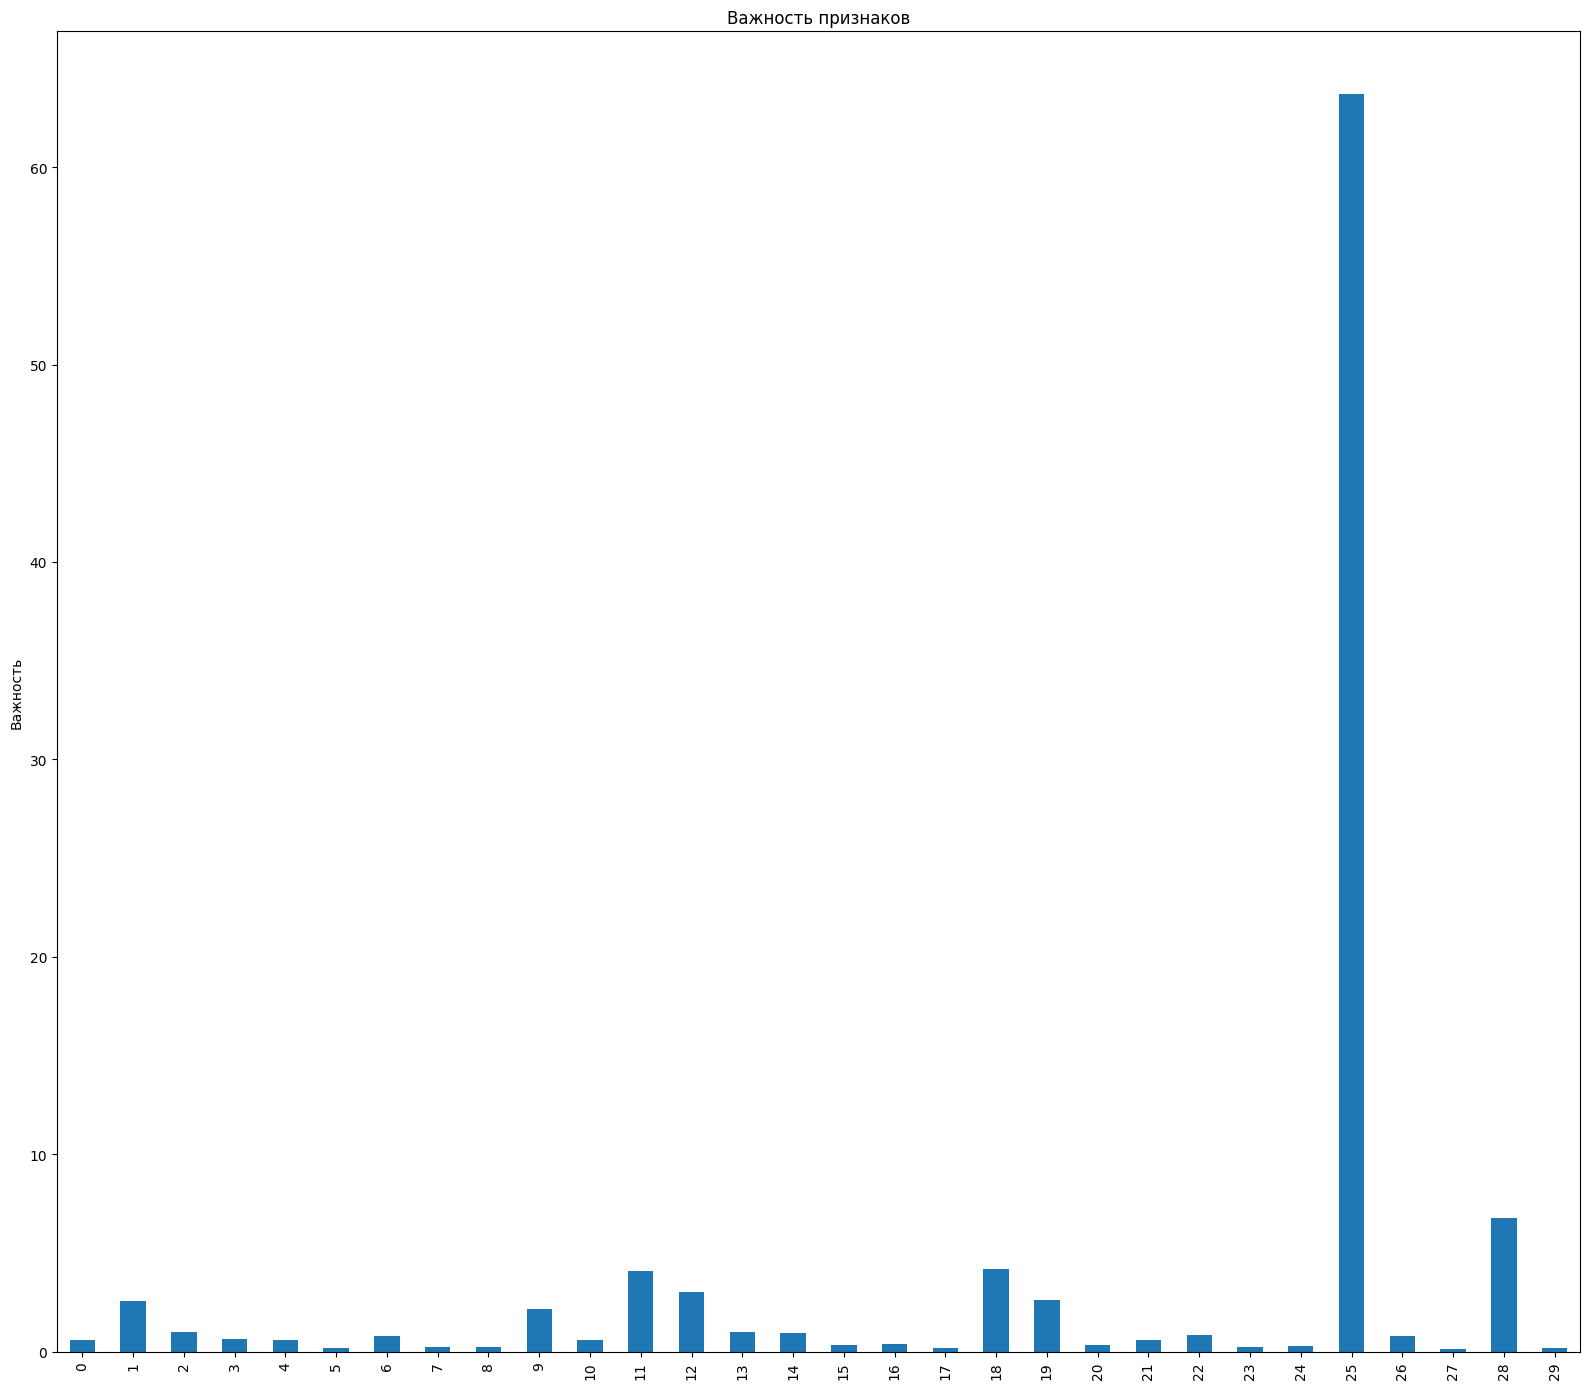

In [11]:
ans = pd.Series(model_1.feature_importances_)
ans_2 = pd.Series([x for x in ans if x > 0])

fig, ax = plt.subplots(figsize=(16,14))
ans_2.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

In [18]:
ans

0      0.000000
1      0.609289
2      2.537336
3      1.014167
4      0.633524
         ...   
203    0.000000
204    0.000000
205    0.000000
206    0.000000
207    0.000000
Length: 208, dtype: float64

In [46]:
print(list(x_train)[0])
print(list(x_train)[2])
print(list(x_train)[11])
print(list(x_train)[13])
print(list(x_train)[14])
print(list(x_train)[31])
print(list(x_train)[32])
print(list(x_train)[34])
print(list(x_train)[35])
print(list(x_train)[65])
print(list(x_train)[66])
print(list(x_train)[68])
print(list(x_train)[89])
print(list(x_train)[146])
print(list(x_train)[148])
print(list(x_train)[149])
print(list(x_train)[150])

balance_amt_avg
balance_amt_min
ogrn_year
max_founderpres
min_founderpres
sum_deb_e_oper_1m
cnt_deb_e_oper_1m
sum_cred_e_oper_1m
cnt_cred_e_oper_1m
sum_deb_e_oper_3m
cnt_deb_e_oper_3m
sum_cred_e_oper_3m
start_cluster
city_ismissing
index_city_code_ismissing
ogrn_month_ismissing
ogrn_year_ismissing


In [51]:
print(list(x_train)[68])

sum_cred_e_oper_3m


In [23]:
print(list(x_train)[89])

start_cluster


In [22]:
cnt = 0
cnt_max = 0
mmax = 0
for x in ans:
    if x > 0:
        print(cnt, x)
        if x > mmax:
            mmax = max(mmax, x)
            cnt_max = cnt
    cnt += 1
print(mmax)
print(cnt_max)

1 0.609289237332141
2 2.5373362669286426
3 1.0141672017023877
4 0.633523703101398
11 0.5772919906679417
12 0.1986833222704449
13 0.8042057167776645
14 0.2144952593707727
15 0.23679078041969076
16 2.1694243911537896
17 0.5756501305006816
31 4.09407425092153
32 2.993826082174622
34 1.0015172863853439
36 0.91678837034072
49 0.33551567310447644
54 0.36327998917422666
56 0.18169775012525
65 4.168346023910994
68 2.6073224035755556
70 0.31711376854034107
72 0.5679232537211559
85 0.8141140402729358
87 0.23126568548598983
88 0.264675940003823
89 63.69922826408851
148 0.7822172320993982
149 0.1393684477052874
150 6.774284061139985
152 0.176583477004348
63.69922826408851
89


In [9]:
model = LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)

KeyboardInterrupt: 

Зададим функцию для взвешенной метрики roc auc

In [14]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [15]:
cluster_weights = pd.read_excel("cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

Проверка работы модели

In [16]:
y_pred_proba = model_1.predict_proba(x_val)
y_pred_proba.shape

(120000, 17)

In [17]:
weighted_roc_auc(y_val, y_pred_proba, model_1.classes_, weights_dict)

0.8822816181778911

## Прогноз на тестовой выборке

In [24]:
test_df.pivot(index="id", columns="date", values="start_cluster").head(3)

date,month_4,month_5,month_6
id,,,
200000,{α},{α},NaN
200001,{α},{α},NaN
200002,{other},{other},NaN


Для того, чтобы сделать прогноз на тестовой выборке, нужно заполнить стартовый кластер. </br>
В качестве базового подхода заполним все стартовые кластеры, самым популярным кластером.

In [25]:
test_df["start_cluster"] = train_df["start_cluster"].mode()[0]
test_df["start_cluster"] = test_df["start_cluster"].astype("category")

In [26]:
sample_submission_df = pd.read_csv("sample_submission.csv")

In [27]:
sample_submission_df.shape

(100000, 18)

In [28]:
sample_submission_df.head()

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
1,200001,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2,200002,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
3,200003,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
4,200004,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


Для тестовой выборки будем использовать только последний месяц

In [29]:
last_m_test_df = test_df[test_df["date"] == "month_6"]
last_m_test_df = last_m_test_df.drop(["id", "date"], axis=1)

In [37]:
last_m_test_df.head(40)

,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,ogrn_days_end_month,ogrn_days_end_quarter,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
2,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,NaN,-1.533705,-1.683741,...,0.006812,0.945281,0.396267,-0.152800,0.549468,0.541020,0.387566,0.268543,0.836079,{α}
5,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,NaN,0.092087,1.220030,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
8,-0.048015,0.448252,-0.125995,-0.047215,channel_code_12,city_14,city_type_0,index_city_code_78,-1.069193,-1.528873,...,0.123154,0.946850,0.453739,2.614870,0.565087,0.818798,4.449125,0.258723,0.627287,{α}
11,-0.156579,-0.204813,-0.125501,-0.156115,channel_code_7,city_31,city_type_0,NaN,-0.256297,-1.257854,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
13,-0.153379,-0.201932,-0.125995,-0.154155,channel_code_7,NaN,NaN,NaN,0.672727,1.413615,...,-0.027573,0.944889,0.396267,-0.165324,0.547032,0.418798,-0.201123,0.250924,0.374540,{α}
16,0.543302,0.712921,-0.125995,0.545933,channel_code_8,NaN,NaN,index_city_code_2,-1.533705,-1.683741,...,-0.028584,0.944497,0.384773,0.245548,0.555773,0.707687,-0.196868,0.251212,0.385529,{α}
19,-0.154442,-0.203773,-0.124206,-0.153972,channel_code_12,city_53,city_type_7557,index_city_code_82,-1.417577,-1.645024,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
22,-0.123198,-0.177398,-0.056818,-0.122630,channel_code_5,city_14,city_type_0,index_city_code_72,-1.417577,0.716710,...,-0.028584,0.944497,0.384773,-0.162297,0.547319,0.441020,-0.156793,0.251501,0.396518,{α}
24,-0.156516,-0.204687,-0.125866,-0.156262,channel_code_9,NaN,NaN,NaN,0.092087,1.142596,...,-0.028584,0.944497,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,{α}
26,-0.156552,-0.204687,-0.125995,-0.156216,channel_code_8,city_1082,city_type_640,NaN,-0.720809,-0.251214,...,-0.028584,0.944497,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,{α}


In [38]:
df_num_dd = last_m_test_df.select_dtypes(include=[np.number])
numeric_cols_dd = df_num_dd.columns.values

for col in numeric_cols_dd:
    missing = last_m_test_df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:
        print('imputing missing values for: {}'.format(col))
        last_m_test_df['{}_ismissing'.format(col)] = missing
        med = last_m_test_df[col].median()
        last_m_test_df[col] = last_m_test_df[col].fillna(med)

imputing missing values for: balance_amt_avg
imputing missing values for: balance_amt_max
imputing missing values for: balance_amt_min
imputing missing values for: balance_amt_day_avg
imputing missing values for: ogrn_days_end_month
imputing missing values for: ogrn_days_end_quarter
imputing missing values for: ft_registration_date
imputing missing values for: max_founderpres
imputing missing values for: min_founderpres
imputing missing values for: ogrn_exist_months
imputing missing values for: sum_of_paym_2m
imputing missing values for: sum_of_paym_6m
imputing missing values for: sum_of_paym_1y
imputing missing values for: cnt_a_oper_1m
imputing missing values for: cnt_b_oper_1m
imputing missing values for: cnt_c_oper_1m
imputing missing values for: cnt_deb_d_oper_1m
imputing missing values for: cnt_cred_d_oper_1m
imputing missing values for: cnt_deb_e_oper_1m
imputing missing values for: cnt_days_deb_e_oper_1m
imputing missing values for: cnt_cred_e_oper_1m
imputing missing values fo

C:\Users\User\AppData\Local\Temp\ipykernel_13020\1291254194.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  last_m_test_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\1291254194.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  last_m_test_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\1291254194.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

In [39]:
df_non_numeric_dd2 = last_m_test_df.select_dtypes(exclude=[np.number])
non_numeric_cols_dd2 = df_non_numeric_dd2.columns.values

for col in non_numeric_cols_dd2:
    missing = last_m_test_df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  # only do the imputation for the columns that have missing values.
        print('imputing missing values for: {}'.format(col))
        last_m_test_df['{}_ismissing'.format(col)] = missing
        
        top = last_m_test_df[col].describe()['top'] # impute with the most frequent value.
        last_m_test_df[col] = last_m_test_df[col].fillna(top)

imputing missing values for: channel_code
imputing missing values for: city
imputing missing values for: city_type
imputing missing values for: index_city_code
imputing missing values for: ogrn_month
imputing missing values for: ogrn_year
imputing missing values for: okved
imputing missing values for: segment


C:\Users\User\AppData\Local\Temp\ipykernel_13020\1745637881.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  last_m_test_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\1745637881.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  last_m_test_df['{}_ismissing'.format(col)] = missing
C:\Users\User\AppData\Local\Temp\ipykernel_13020\1745637881.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

In [41]:
data = Pool(data=last_m_test_df, cat_features=cat_cols)
test_pred_proba = model_1.predict_proba(data)
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model_1.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

In [42]:
test_pred_proba_df.shape

(100000, 17)

In [45]:
test_pred_proba_df.head(30)

,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,0.028221,0.040722,0.023584,0.032301,0.019352,0.012047,0.012617,0.012028,0.020302,0.019788,0.018310,0.012990,0.014839,0.011723,0.015285,0.694173,0.011718
1,0.026785,0.400336,0.014751,0.017968,0.012964,0.012552,0.012485,0.012195,0.013997,0.029531,0.014403,0.012734,0.013057,0.012145,0.013214,0.368377,0.012504
2,0.039099,0.066536,0.024521,0.042849,0.021041,0.012576,0.014578,0.013374,0.022571,0.018723,0.018898,0.014162,0.015434,0.012168,0.018270,0.633030,0.012169
3,0.033104,0.420047,0.014050,0.016900,0.012623,0.012579,0.012337,0.012035,0.013920,0.040086,0.014161,0.012226,0.013244,0.011971,0.012632,0.336011,0.012072
4,0.028531,0.089254,0.017388,0.023005,0.013715,0.011968,0.011479,0.011155,0.015677,0.039567,0.014533,0.011725,0.014435,0.011087,0.012054,0.663294,0.011133
5,0.040761,0.042343,0.026576,0.045387,0.021719,0.012338,0.013882,0.013113,0.024220,0.020398,0.019387,0.014842,0.015691,0.011935,0.017272,0.648208,0.011930
6,0.023116,0.427627,0.016018,0.021304,0.013332,0.012456,0.012522,0.012341,0.013599,0.019555,0.013919,0.012735,0.013166,0.012312,0.013372,0.350185,0.012438
7,0.023825,0.033651,0.029464,0.033625,0.016087,0.011450,0.011713,0.011408,0.015769,0.016225,0.015173,0.013024,0.013954,0.011272,0.013299,0.718760,0.011301
8,0.034187,0.176892,0.017395,0.021970,0.014080,0.013226,0.012894,0.012504,0.016002,0.045896,0.015962,0.013169,0.014520,0.012450,0.013476,0.552670,0.012707
9,0.030199,0.157647,0.019081,0.025697,0.014588,0.013200,0.013048,0.012628,0.016161,0.039051,0.016659,0.013786,0.014536,0.012633,0.013673,0.574531,0.012881


In [44]:
sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("baseline_submission.csv", index=False)